In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.color import rgb2gray
import wandb

from color_train import train_model
from itertools import product
import random

In [2]:
CONFIG = {
    'wandb_project': "CIFAR10-Colorization-Q2",
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    
    # Model Architecture Params
    'NIC': 1,               # Number of Input Channels (Grayscale)
    'NUM_CLASSES': 24,      # NC: Number of Output Classes (Color Centroids)
    'NF': 64,               # Base Number of Filters in the first layer (Feature Maps)
    'kernel_size_conv': 3,  # Standard kernel size for Conv2d
    'kernel_size_tconv': 2, # Kernel size for ConvTranspose2d (to double size)

    # Training Hyperparameters
    'learning_rate': 1e-2,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': 'Adam',    # Options: 'Adam', 'SGD'
    'loss_fn': 'CrossEntropyLoss',
    'num_workers': 4,       # Dataloader workers
    'centroids_path': 'color_centroids.npy' # Path to your k-means result file
}

In [3]:
# Apply seed for reproducibility
torch.manual_seed(CONFIG['seed'])
if CONFIG['device'] == 'cuda':
    torch.cuda.manual_seed(CONFIG['seed'])

wandb: Currently logged in as: 0410shubham (0410shubham-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
Starting training on cuda...
Epoch 1/25 | Train Loss: 1.9526 | Val Loss: 1.8276
-> Saved new best model with Val Loss: 1.8276
Epoch 2/25 | Train Loss: 1.7863 | Val Loss: 1.7526
-> Saved new best model with Val Loss: 1.7526
Epoch 3/25 | Train Loss: 1.7233 | Val Loss: 1.7222
-> Saved new best model with Val Loss: 1.7222
Epoch 4/25 | Train Loss: 1.6783 | Val Loss: 1.6672
-> Saved new best model with Val Loss: 1.6672
Epoch 5/25 | Train Loss: 1.6463 | Val Loss: 1.6907
Epoch 6/25 | Train Loss: 1.6212 | Val Loss: 1.6059
-> Saved new best model with Val Loss: 1.6059
Epoch 7/25 | Train Loss: 1.6081 | Val Loss: 1.7002
Epoch 8/25 | Train Loss: 1.5949 | Val Loss: 1.5845
-> Saved new best model with Val Loss: 1.5845
Epoch 9/25 | Train Loss: 1.5825 | Val Loss: 1.5963
Epoch 10/25 | Train Loss: 1.5717 | Val Loss: 1.5624
-> Saved new best model with Val Loss: 1.5624
Epoch 11/25 | Train Loss: 1.5629 | Val Loss: 1.5753
Epoch 12/2

/ssd_scratch/shubham/smai-a4/color/color_train.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(checkpoint_path))


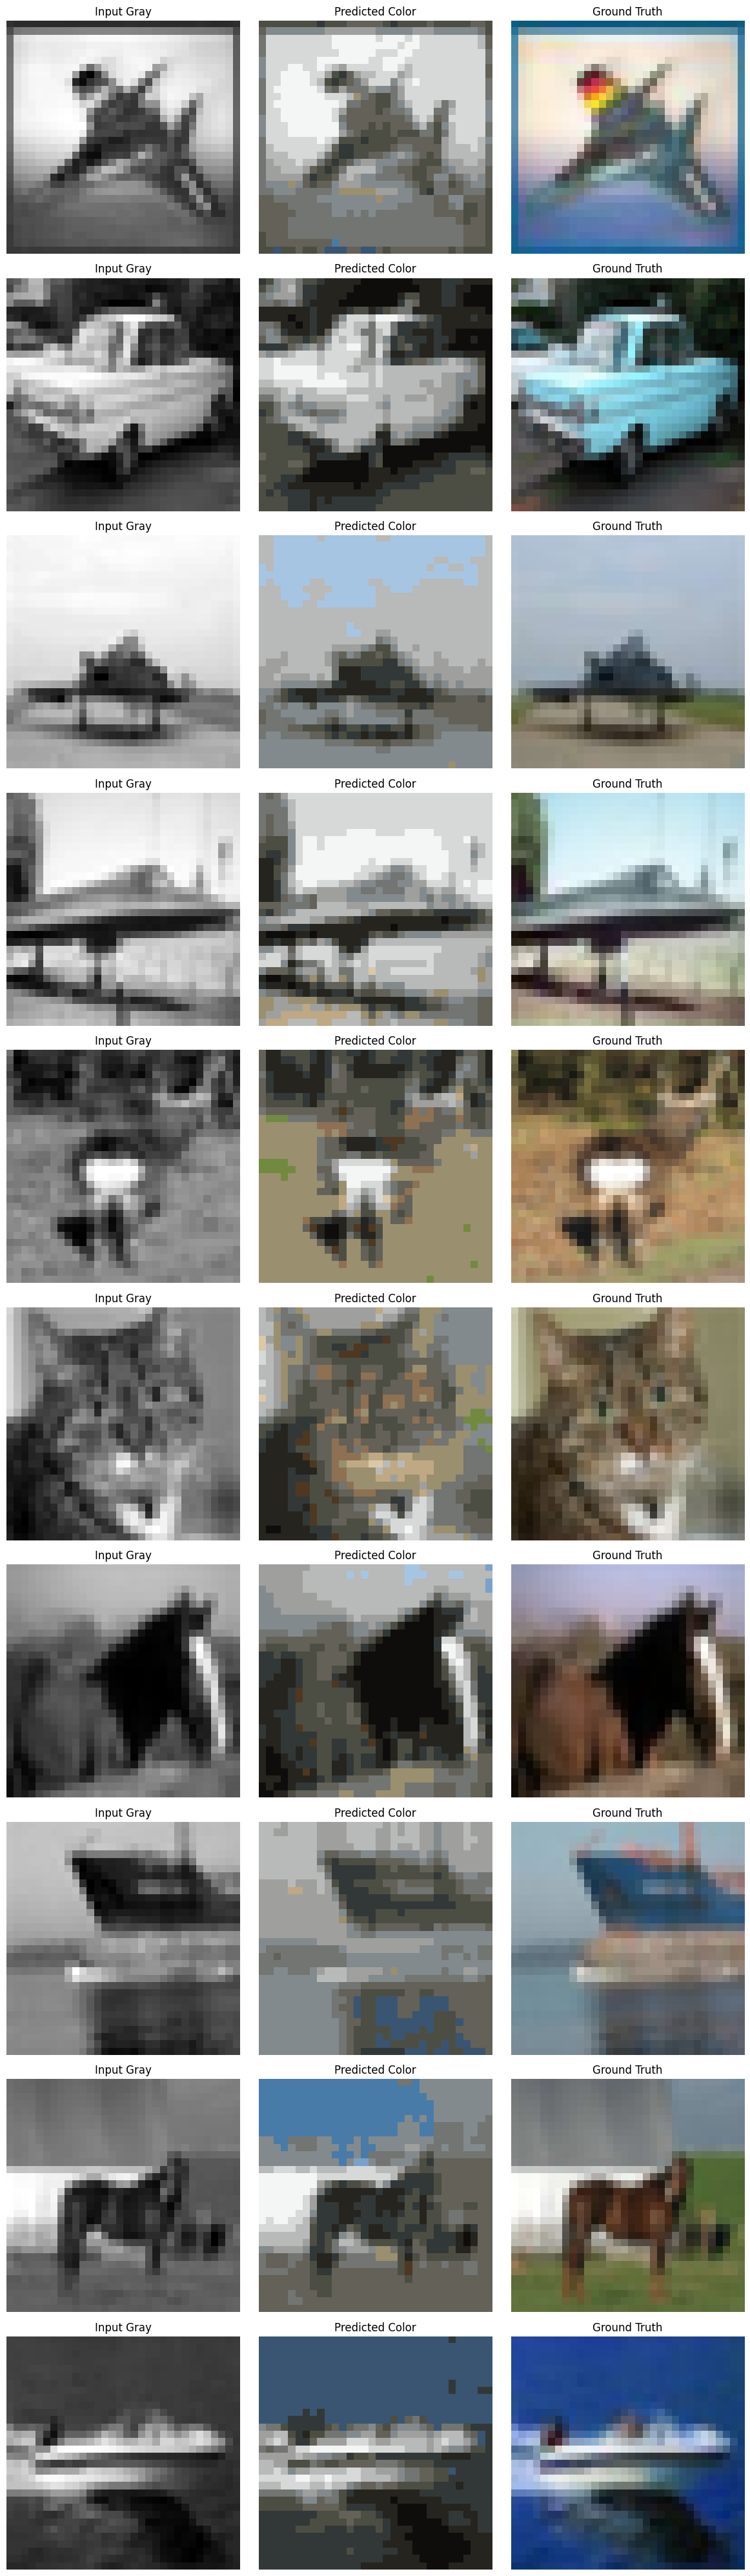

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▃▅▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁
epoch,24
train_loss,1.49717
val_loss,1.48773


(1.4971704215240478, 1.4877313884735108)

In [4]:
train_model(config=CONFIG)

# Analytical Questions (10 pts)
For your Model Architecture compute (symbolically in terms of NIC, NF, NC):
1. Number of weights (ignore biases and BatchNorm parameters).
2. Number of outputs (total activation elements across all layers for a single input).
3. Number of connections (sum over layers of weight count times number of input acti-
vation elements each weight connects to).
Repeat the three quantities for input spatial size doubled (64×64). Show each step and
state assumptions (padding/stride/kernels).

This is an analytical breakdown of the given $\text{ColorizerCNN}$ architecture.

### 📐 $\text{ColorizerCNN}$ Architecture Analysis

The analysis is based on a **$32 \times 32$ input image** (CIFAR-10 size) and the following symbolic parameters from the $\text{CONFIG}$:
* **$\text{NIC}$** (Input Channels): 1
* **$\text{NF}$** (Base Filters): 64
* **$\text{NC}$** (Output Classes/Channels): 24
* **$K_{\text{CONV}}$** (Conv Kernel Size): 3
* **$K_{\text{TCONV}}$** (ConvTranspose Kernel Size): 2

---

## 1. Number of Weights ($\boldsymbol{W}$)

The number of weights in a $\text{Conv2d}$ or $\text{ConvTranspose2d}$ layer is:
$$W = (\text{Input Channels}) \times (\text{Output Channels}) \times (\text{Kernel Area})$$

| Layer | Type | Input Shape ($\boldsymbol{C_{\text{in}}}$) | Output Shape ($\boldsymbol{C_{\text{out}}}$) | Kernel Area ($\boldsymbol{K^2}$) | Weights ($\boldsymbol{W_{\text{layer}}}$) |
| :--- | :--- | :--- | :--- | :--- | :--- |
| $\text{enc1}$ | $\text{Conv2d}$ | $\text{NIC}$ | $\text{NF}$ | $K_{\text{CONV}}^2 = 9$ | $9 \cdot \text{NIC} \cdot \text{NF}$ |
| $\text{enc2}$ | $\text{Conv2d}$ | $\text{NF}$ | $2\text{NF}$ | $K_{\text{CONV}}^2 = 9$ | $9 \cdot \text{NF} \cdot 2\text{NF} = 18\text{NF}^2$ |
| $\text{enc3}$ | $\text{Conv2d}$ | $2\text{NF}$ | $4\text{NF}$ | $K_{\text{CONV}}^2 = 9$ | $9 \cdot 2\text{NF} \cdot 4\text{NF} = 72\text{NF}^2$ |
| $\text{dec1}$ | $\text{ConvT}$ | $4\text{NF}$ | $2\text{NF}$ | $K_{\text{TCONV}}^2 = 4$ | $4 \cdot 4\text{NF} \cdot 2\text{NF} = 32\text{NF}^2$ |
| $\text{dec2}$ | $\text{ConvT}$ | $2\text{NF}$ | $\text{NF}$ | $K_{\text{TCONV}}^2 = 4$ | $4 \cdot 2\text{NF} \cdot \text{NF} = 8\text{NF}^2$ |
| $\text{dec3}$ | $\text{ConvT}$ | $\text{NF}$ | $\text{NC}$ | $K_{\text{TCONV}}^2 = 4$ | $4 \cdot \text{NF} \cdot \text{NC}$ |
| $\text{classifier}$ | $\text{Conv2d}$ | $\text{NC}$ | $\text{NC}$ | $1^2 = 1$ | $1 \cdot \text{NC} \cdot \text{NC} = \text{NC}^2$ |

$$\boldsymbol{W}_{\text{total}} = (9 \cdot \text{NIC} \cdot \text{NF}) + (18\text{NF}^2) + (72\text{NF}^2) + (32\text{NF}^2) + (8\text{NF}^2) + (4 \cdot \text{NF} \cdot \text{NC}) + (\text{NC}^2)$$

$$\boldsymbol{W}_{\text{total}} = \text{NC}^2 + (4\text{NF} \cdot \text{NC}) + (130\text{NF}^2) + (9\text{NIC} \cdot \text{NF})$$

---

## 2. Number of Outputs ($\boldsymbol{A}$) (Total Activation Elements)

The number of outputs (activations) in a layer is:
$$A = (\text{Output Channels}) \times (\text{Output Height}) \times (\text{Output Width})$$

**Assumptions on Spatial Size ($H \times W$):**
* $\text{ConvBlock}$ (stride=1, $K=3$): Output size is $\text{Input size}$.
* $\text{MaxPool2d}$ (stride=2, $K=2$): Output size is $\text{Input size} / 2$.
* $\text{ConvTransposeBlock}$ (stride=2, $K=2$): Output size is $\text{Input size} \times 2$.

| Layer/Block | Output Shape ($\boldsymbol{C_{\text{out}}}, \boldsymbol{H_{\text{out}}}, \boldsymbol{W_{\text{out}}}$) | Activations ($\boldsymbol{A_{\text{layer}}}$) |
| :--- | :--- | :--- |
| $\text{enc1}$ ($\text{ReLU}$ output) | $\text{NF}, 32, 32$ | $1024 \cdot \text{NF}$ |
| $\text{pool1}$ ($\text{MaxPool}$ output) | $\text{NF}, 16, 16$ | $256 \cdot \text{NF}$ |
| $\text{enc2}$ ($\text{ReLU}$ output) | $2\text{NF}, 16, 16$ | $512 \cdot \text{NF}$ |
| $\text{pool2}$ ($\text{MaxPool}$ output) | $2\text{NF}, 8, 8$ | $128 \cdot \text{NF}$ |
| $\text{enc3}$ ($\text{ReLU}$ output) | $4\text{NF}, 8, 8$ | $256 \cdot \text{NF}$ |
| $\text{pool3}$ ($\text{MaxPool}$ output) | $4\text{NF}, 4, 4$ | $64 \cdot \text{NF}$ |
| $\text{dec1}$ ($\text{ReLU}$ output) | $2\text{NF}, 8, 8$ | $128 \cdot \text{NF}$ |
| $\text{dec2}$ ($\text{ReLU}$ output) | $\text{NF}, 16, 16$ | $256 \cdot \text{NF}$ |
| $\text{dec3}$ ($\text{ReLU}$ output) | $\text{NC}, 32, 32$ | $1024 \cdot \text{NC}$ |
| $\text{classifier}$ ($\text{Conv2d}$ output) | $\text{NC}, 32, 32$ | $1024 \cdot \text{NC}$ |

$$\boldsymbol{A}_{\text{total}} = (\sum_{\text{pools, encs, decs}} A) + A_{\text{classifier}}$$
$$\boldsymbol{A}_{\text{total}} = (1024 + 256 + 512 + 128 + 256 + 64 + 128 + 256) \cdot \text{NF} + (1024 \cdot \text{NC}) + (1024 \cdot \text{NC})$$
$$\boldsymbol{A}_{\text{total}} = (2624 \cdot \text{NF}) + (2048 \cdot \text{NC})$$

---

## 3. Number of Connections ($\boldsymbol{C}$)

The number of connections (multiplications/MACs) for a single forward pass through a convolutional layer is:
$$C_{\text{layer}} = (\text{Number of Weights}) \times (\text{Output Height}) \times (\text{Output Width})$$
$$C_{\text{layer}} = W_{\text{layer}} \times H_{\text{out}} \times W_{\text{out}}$$

| Layer | Weights ($\boldsymbol{W_{\text{layer}}}$) | $\boldsymbol{H_{\text{out}}} \times \boldsymbol{W_{\text{out}}}$ | Connections ($\boldsymbol{C_{\text{layer}}}$) |
| :--- | :--- | :--- | :--- |
| $\text{enc1}$ | $9 \cdot \text{NIC} \cdot \text{NF}$ | $32 \times 32 = 1024$ | $9216 \cdot \text{NIC} \cdot \text{NF}$ |
| $\text{enc2}$ | $18\text{NF}^2$ | $16 \times 16 = 256$ | $4608 \cdot \text{NF}^2$ |
| $\text{enc3}$ | $72\text{NF}^2$ | $8 \times 8 = 64$ | $4608 \cdot \text{NF}^2$ |
| $\text{dec1}$ | $32\text{NF}^2$ | $8 \times 8 = 64$ | $2048 \cdot \text{NF}^2$ |
| $\text{dec2}$ | $8\text{NF}^2$ | $16 \times 16 = 256$ | $2048 \cdot \text{NF}^2$ |
| $\text{dec3}$ | $4 \cdot \text{NF} \cdot \text{NC}$ | $32 \times 32 = 1024$ | $4096 \cdot \text{NF} \cdot \text{NC}$ |
| $\text{classifier}$ | $\text{NC}^2$ | $32 \times 32 = 1024$ | $1024 \cdot \text{NC}^2$ |

$$\boldsymbol{C}_{\text{total}} = 1024 \cdot \text{NC}^2 + 4096 \cdot \text{NF} \cdot \text{NC} + (4608 + 4608 + 2048 + 2048)\text{NF}^2 + 9216 \cdot \text{NIC} \cdot \text{NF}$$

$$\boldsymbol{C}_{\text{total}} = 1024 \cdot \text{NC}^2 + (4096 \cdot \text{NF} \cdot \text{NC}) + (13312 \cdot \text{NF}^2) + (9216 \cdot \text{NIC} \cdot \text{NF})$$

---

## Analysis for Doubled Input Size ($64 \times 64$)

If the input size is doubled to $64 \times 64$, **only the spatial activation elements and connections change**. The **Number of Weights ($\boldsymbol{W}$)** remains **unchanged** as it depends only on the number of channels and kernel sizes, not the input spatial size.

$$\boldsymbol{W}_{\text{total}} = \text{NC}^2 + (4\text{NF} \cdot \text{NC}) + (130\text{NF}^2) + (9\text{NIC} \cdot \text{NF})$$

### 2. Number of Outputs ($\boldsymbol{A}$) for $64 \times 64$ Input

The spatial sizes $(H \times W)$ are quadrupled compared to the $32 \times 32$ case for every layer's output.

$$\boldsymbol{A}_{\text{total}, 64 \times 64} = 4 \times \boldsymbol{A}_{\text{total}, 32 \times 32}$$

$$\boldsymbol{A}_{\text{total}, 64 \times 64} = 4 \cdot [(2624 \cdot \text{NF}) + (2048 \cdot \text{NC})]$$

$$\boldsymbol{A}_{\text{total}, 64 \times 64} = (10496 \cdot \text{NF}) + (8192 \cdot \text{NC})$$

### 3. Number of Connections ($\boldsymbol{C}$) for $64 \times 64$ Input

Since $C_{\text{layer}} = W_{\text{layer}} \times H_{\text{out}} \times W_{\text{out}}$ and the weights are constant, but the output area $(H_{\text{out}} \times W_{\text{out}})$ is quadrupled for every layer, the total connections will also be **quadrupled**.

$$\boldsymbol{C}_{\text{total}, 64 \times 64} = 4 \times \boldsymbol{C}_{\text{total}, 32 \times 32}$$

$$\boldsymbol{C}_{\text{total}, 64 \times 64} = 4 \cdot [1024 \cdot \text{NC}^2 + 4096 \cdot \text{NF} \cdot \text{NC} + 13312 \cdot \text{NF}^2 + 9216 \cdot \text{NIC} \cdot \text{NF}]$$

$$\boldsymbol{C}_{\text{total}, 64 \times 64} = (4096 \cdot \text{NC}^2) + (16384 \cdot \text{NF} \cdot \text{NC}) + (53248 \cdot \text{NF}^2) + (36864 \cdot \text{NIC} \cdot \text{NF})$$

# Hyperparameter Tuning
> check out color_sweep.ipynb file